In [20]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label,sum_labels
from scipy.signal import savgol_filter
import os, pickle

In [22]:
def convert_bool_to_binary(bool_array):

    return copy.copy(np.array(bool_array,"int"))
    # binary_mask = np.zeros(bool_mask.shape,"int")
    # binary_mask[bool_mask] = 1
    #  binary_mask

def column_dilation(array):
    zeors = np.zeros((array.shape[0],array.shape[1]*2))
    zeors[:,list(range(0,zeors.shape[1],2))] = array
    return zeors

def interpolate_data(array,undetected_bool):
    array = copy.copy(array)
    for col in range(array.shape[1]):
        fp = array[:,col]
        xp = np.arange(len(fp))
        cells_to_interpolate = undetected_bool[:,col]
        fp_nonan = fp[np.invert(cells_to_interpolate)]
        xp_nonan = xp[np.invert(cells_to_interpolate)]
        array[:,col] = np.interp(xp, xp_nonan, fp_nonan)
    return array

In [218]:
class Prepare_data:
    def __init__(self,directory,save_events=False):
        self.directory = directory
        self.load_data(directory)
        self.original_N_ants = copy.copy(self.N_ants_around_springs)
        self.load_starting_frame()
        self.undetected_springs_bool = np.isnan(self.springs_length)
        self.undetected_springs_for_long_time = self.filter_continuity(convert_bool_to_binary(self.undetected_springs_bool),min_size=8)
        self.find_cells_to_interpolate()
        self.N_ants_proccessing()
        self.springs_length_proccessing()
        self.springs_rest_lengths()
        self.attaches_events(self.N_ants_around_springs)
        self.labeled_zero_to_one_filtered = self.fiter_attaches_events(self.labeled_zero_to_one)
        if save_events:
            self.save_events(self.labeled_zero_to_one_filtered,self.directory)

    def load_data(self,directory):
        self.N_ants_around_springs = np.loadtxt(f"{directory}N_ants_around_springs.csv",delimiter=",")
        self.size_ants_around_springs = np.loadtxt(f"{directory}size_ants_around_springs.csv",delimiter=",")
        self.springs_length = np.loadtxt(f"{directory}springs_length.csv",delimiter=",")
        self.springs_angles_to_nest = np.loadtxt(f"{directory}springs_angles_to_nest.csv",delimiter=",")
        self.springs_angles_to_object = np.loadtxt(f"{directory}springs_angles_to_object.csv",delimiter=",")

    def load_starting_frame(self):
        path_parts =  os.path.normpath(self.directory).split('\\')
        with open(os.path.join("Z:/Dor_Gabay/videos",path_parts[-3],"video_preferences.pickle"), 'rb') as handle:
            # self.startig_frame = pickle.load(handle)["Z:\\Dor_Gabay\\videos\\10.9\\plus0_force\\S5200007.MP4"]['starting_frame']
            path = f"Z:\\Dor_Gabay\\videos\\{path_parts[-3]}\\{path_parts[-2]}\\{path_parts[-1]}.MP4"
            self.startig_frame = pickle.load(handle)[path]['starting_frame']
            print("startig_frame:",self.startig_frame)

    def find_cells_to_interpolate(self):
        self.cells_to_interpolate = copy.copy(self.undetected_springs_bool)
        self.cells_to_interpolate[self.undetected_springs_for_long_time] = False

    def filter_continuity(self,binary_array,min_size=0,max_size=np.inf):
        binary_array_dilated = column_dilation(binary_array)
        labeled,labels = label(binary_array_dilated)
        labels = np.arange(labels+1)[1:]
        labeled_summed = sum_labels(binary_array_dilated,labeled,index=labels).astype(int)
        labels_to_remove = labels[np.invert((labeled_summed>min_size)&(labeled_summed<max_size))]
        labeled[np.isin(labeled,labels_to_remove)]=0
        labeled = labeled[:,list(range(0,labeled.shape[1],2))]
        return labeled>=1

    def N_ants_proccessing(self):
        self.N_ants_around_springs = np.round(interpolate_data(self.N_ants_around_springs,self.cells_to_interpolate))
        self.N_ants_around_springs[np.isnan(self.N_ants_around_springs)] = 0
        self.N_ants_around_springs = self.smoothing_N_ants(self.N_ants_around_springs)
        self.N_ants_around_springs[self.undetected_springs_for_long_time] = np.nan
        all_small_attaches = np.zeros(self.N_ants_around_springs.shape,int)
        for n in np.unique(self.N_ants_around_springs)[1:]:
            if not np.isnan(n):
                short_attaches = self.filter_continuity(self.N_ants_around_springs==n,max_size=30)
                all_small_attaches[short_attaches] = 1
        self.N_ants_around_springs = np.round(interpolate_data(self.N_ants_around_springs,all_small_attaches.astype(bool)))

        # without_switching = self.clean_ant_switching(long_ant_attaches)
        # without_switching[self.undetected_springs_for_long_time] = np.nan
        # single_ant_attached_filtered = self.filter_continuity(without_switching==1,min_size=50)
        # self.single_ant_attached_labeled, num_labels_zero = label(column_dilation(convert_bool_to_binary(single_ant_attached_filtered)))
        # self.single_ant_attached_labeled = self.single_ant_attached_labeled[:,list(range(0,self.single_ant_attached_labeled.shape[1],2))]
        # self.N_ants_around_springs[self.undetected_springs_for_long_time] = np.nan

    def springs_length_proccessing(self):
        self.springs_length_processed = copy.copy(self.springs_length)
        self.springs_length_processed[np.invert(self.undetected_springs_bool)&np.isnan(self.springs_length)]=0
        self.springs_length_processed = interpolate_data(self.springs_length_processed,self.cells_to_interpolate)


    def smoothing_N_ants(self,array):
        for col in range(array.shape[1]):
            array[:,col] = np.abs(np.round(savgol_filter(array[:,col], 31, 2)))
        return array

    def attaches_events(self,N_ants_array):
        N_ants_array = copy.copy(N_ants_array)
        N_ants_array = column_dilation(N_ants_array)
        diff = np.vstack((np.diff(N_ants_array,axis=0),np.zeros(N_ants_array.shape[1]).reshape(1,N_ants_array.shape[1])))
        labeled_single_attaches,num_labels_single = label(convert_bool_to_binary(N_ants_array==1))
        labeled_single_attaches_adapted = np.vstack((labeled_single_attaches,np.zeros(labeled_single_attaches.shape[1]).reshape(1,labeled_single_attaches.shape[1])))[1:,:]
        labels_0_to_1 = np.unique(labeled_single_attaches_adapted[(diff==1)&(N_ants_array==0)])
        labels_1_to_0 = np.unique(labeled_single_attaches_adapted[(diff==-1)&(N_ants_array==1)])
        self.labeled_zero_to_one,_ = label(np.isin(labeled_single_attaches,labels_0_to_1))
        self.labeled_zero_to_one = self.labeled_zero_to_one[:,list(range(0,self.labeled_zero_to_one.shape[1],2))]
        self.labeled_one_to_zero,_ = label(np.isin(labeled_single_attaches,labels_1_to_0))
        self.labeled_one_to_zero = self.labeled_one_to_zero[:,list(range(0,self.labeled_one_to_zero.shape[1],2))]

    def fiter_attaches_events(self, labeled):
        EVENT_LENGTH = 150
        PRE_EVENT_LENGTH = 15
        ar = self.labeled_zero_to_one
        events_to_keep = []
        self.events_sts = []
        for event in np.unique(ar):
            frames = np.where(ar[:,:]==event)[0]
            pre_frames = np.arange(frames[0]-PRE_EVENT_LENGTH,frames[0]-1,1)
            spring = np.where(ar[:,:]==event)[1][0]
            # if len(frames)>EVENT_LENGTH:
            if True:
                if np.sum(np.isnan(self.N_ants_around_springs[frames[0]-10:frames[0],spring]))==0:
                    pre_frames_lengths = np.take(self.springs_length_processed[:,spring],pre_frames)
                    pre_frames_median = np.nanmedian(pre_frames_lengths)
                    # if (not pre_frames_median<self.rest_length*0.8) & (not pre_frames_median>self.rest_length*1.2):
                    if True:
                        self.events_sts.append(np.nanstd(pre_frames_lengths)/pre_frames_median)
                        # if not np.std()
                        events_to_keep.append(event)
        labeled = copy.copy(labeled)
        labeled[np.invert(np.isin(labeled,events_to_keep))] = 0
        labeled, _ =  label(labeled!=0)
        return labeled

    def clean_ant_switching(self,N_ants_array):
        N_ants_array = copy.copy(N_ants_array)
        N_ants_array = column_dilation(N_ants_array)
        labeled_all_attaches,num_labels_all = label(convert_bool_to_binary(N_ants_array>=1))

        labels_to_remove = np.unique(labeled_all_attaches[N_ants_array>1&np.isnan(N_ants_array)])
        N_ants_array[np.isin(labeled_all_attaches,labels_to_remove)] = 0
        N_ants_array = N_ants_array[:,list(range(0,N_ants_array.shape[1],2))]
        return N_ants_array

    def filter_by_ant_size(self):
        from scipy.ndimage import median
        self.size_ants_around_springs[np.isnan(self.size_ants_around_springs)] = 0
        N_ants_for_mean = copy.copy(self.N_ants_around_springs)
        N_ants_for_mean[self.size_ants_around_springs==0] = 0
        median_size_over_N_ants = median(self.size_ants_around_springs,N_ants_for_mean.astype(int),index=np.unique(N_ants_for_mean))
        # size_ants_around_springs[(smoothed_N_ants_without_short_attaches==1)&size_ants_around_springs*1.3<median_size_over_N_ants[1]] = 0
        false_single_ants = (self.N_ants_around_springs==1)&(self.size_ants_around_springs>median_size_over_N_ants[1]*1.5)

    def springs_rest_lengths(self):
        ar = copy.copy(self.springs_length_processed)
        ar[self.N_ants_around_springs!=0] = np.nan
        ar = np.sort(ar,axis=0)
        self.rest_lenghts = np.nanmedian(ar[:100],axis=0)
        self.rest_length = np.median(self.rest_lenghts)

    def events_hist(self):
        number_of_seconds = sum_labels(convert_bool_to_binary(self.single_ant_attached_labeled>=1),self.single_ant_attached_labeled,np.unique(self.single_ant_attached_labeled))/50
        plt.hist(number_of_seconds,bins=100)
        plt.show()

    def save_events(self,labeled_events,output_dir):
        events = np.unique(labeled_events)[1:]
        events_array = np.zeros((len(events),4),"int")
        for event in events:
            spring = np.where(labeled_events[:,:]==event)[1][0]
            frames = np.where(labeled_events[:,:]==event)[0]
            start_frame, end_frame = frames[0]+self.startig_frame,frames[-1]+self.startig_frame
            events_array[event-1,:] = event,spring,start_frame,end_frame
        headers = 'event_num,spring,start,end'
        np.savetxt(output_dir + '/single_ants_events.csv', events_array, delimiter=',',header=headers)

In [287]:
# files = Prepare_data("Z:/Dor_Gabay/data/summer_2022/10.9/plus0_force/S5200007/",save_events = True)
files = Prepare_data("Z:/Dor_Gabay/data/test/10.9/plus0_force/S5200007/",save_events = True)
# files = Prepare_data("Z:/Dor_Gabay/data/test/18.9.22/plus0.5mm_force/S5290002/",save_events = True)

startig_frame: 75


In [261]:
files.original_N_ants

array([[1., 2., 1., ..., 1., 2., 2.],
       [1., 2., 1., ..., 1., 2., 2.],
       [1., 2., 1., ..., 1., 2., 2.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 1., 0.]])

In [286]:
files.N_ants_around_springs

array([[ 0.,  0.,  0., ...,  0., nan, nan],
       [ 0.,  0.,  0., ...,  0., nan, nan],
       [ 0.,  0.,  0., ...,  0., nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [92]:
np.unique(files.N_ants_around_springs[files.labeled_zero_to_one_filtered!=0])

array([1.])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70]
75
start_frame:  210
end_frame:  871


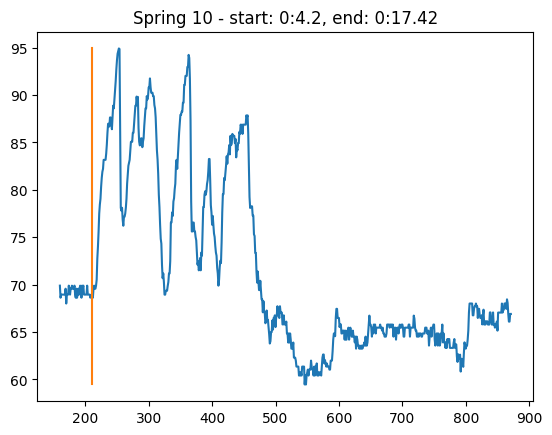

In [294]:
n= 2
a = files.labeled_zero_to_one_filtered
print(np.unique(a)[1:])
frames_ori = np.where(a[:,:]==n)[0]
x = np.append(np.arange(frames_ori[0]-50,frames_ori[0]-1,1),frames_ori)
# spring = np.unique(np.where(a[:,:]==n)[1])[0]
spring = np.where(a[:,:]==n)[1][0]
y = files.springs_length_processed[:,spring]
y = np.take(y,x)
x = x+files.startig_frame
print(files.startig_frame)
plt.plot(x,y)
plt.plot(np.repeat(frames_ori[0]+files.startig_frame,len(x)),np.linspace(np.nanmin(y),np.nanmax(y),len(x)))
start_frame, end_frame = frames_ori[0]+files.startig_frame,frames_ori[-1]+files.startig_frame
start_min, end_min = int(start_frame/50//60),int(end_frame/50//60)
start_sec, end_sec = start_frame/50-60*start_min,end_frame/50-60*start_min

print("start_frame: ",start_frame)

print("end_frame: ",end_frame)
plt.title(f"Spring {spring} - start: {start_min}:{start_sec}, end: {end_min}:{end_sec}")
# plt.ylim((0,40))
plt.show()